<center> 
    <h1><b>CSC173: Group Activity 1<b></h1>
</center>

<center><i>Members: Febe Belvis, Kervin Paalisbo, Joshua Radz Adlaon</i></center>

This notebook documents this group's Activity 1, where the goal is to implement a neural network from scratch (without using machine learning libraries such as TensorFlow or PyTorch). The neural network will be trained and evaluated on the Breast Cancer dataset from the UCI Machine Learning Repository.

***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo # to directly import the dataset from its repo


## **Loading and Preprocessing the Dataset**

Before we use train the network, we import the dataset from its repository using the ```ucimlrepo``` library. 

In [ ]:
breast_cancer = fetch_ucirepo(id=17) # import the dataset from the ML repo

# extract features and its values/targets
X = breast_cancer.data.features
y = breast_cancer.data.targets

# combine into one DataFrame
df = pd.concat([X, y], axis=1)

We then preprocess the dataset by standardizing the feature names and converting the diagnosis values from ```'M/B'``` to ```'1/0'```.

In [ ]:
# lowercase 'diagnosis' column for standardization 
df.rename(columns={df.columns[-1]: 'diagnosis'}, inplace=True)

# convert diagnosis values to binary (M=1, B=0)
y = y['Diagnosis'].map({'M':1,'B':0})
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

df.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1



## **Feature Selection (using Correlation) and Standardization**
In this step, we identify the two features most correlated with the target ```diagnosis```. <br>We use the **Pearson correlation coefficient**, particularly panda's ```corr``` function to measures the linear relationship between two variables. 

A higher absolute correlation value (closer to 1 or -1) means that changes in the feature are strongly associated with changes in the target, making that feature more useful for prediction.


In [ ]:
corr = df.corr(method='pearson')['diagnosis'].abs().sort_values(ascending=False)
corr.head(5)

diagnosis          1.000000
concave_points3    0.793566
perimeter3         0.782914
concave_points1    0.776614
radius3            0.776454
perimeter1         0.742636
area3              0.733825
radius1            0.730029
area1              0.708984
concavity1         0.696360
Name: diagnosis, dtype: float64


<span style="font-size:12px">*GeeksforGeeks. (2025, July 23). Pearson Correlation Coefficient. GeeksforGeeks. https://www.geeksforgeeks.org/maths/pearson-correlation-coefficient/*</span>
<br><span style="font-size:12px">*GeeksforGeeks. (2025b, July 11). Pandas DataFrame corr() Method. GeeksforGeeks. https://www.geeksforgeeks.org/pandas/python-pandas-dataframe-corr/*</span>




<br><br>Since we're limited to using only 2 input features, we pick the top 2 most correlated features to ```diagnosis```

In [ ]:
top_features = corr.index[1:3].tolist()

# extract top 2 correlated features
X_selected = X[top_features]

print("Selected features:", top_features)

Selected features: ['concave_points3', 'perimeter3']


The next step is to standardize the features using the following formula:
$$
X'_j = (X_j - μ_j) / σ_j
$$

This helps gradient descent converge faster and prevents features with large scale dominating updates.

In [ ]:
# Standardize features  
X_scaled = (X_selected - X_selected.mean()) / X_selected.std()
X_np = X_scaled.values
y_np = y.values.reshape(-1, 1)

***
## **Activation functions**

Activation functions introduce **non-linearity** into the network, allowing it to learn complex patterns.
In this notebook, we use ```ReLU (Rectified Linear Unit):``` and ```Sigmoid:``` as shown below:

In [ ]:
def relu(x): 
    return np.maximum(0, x)

def relu_derivative(x): 
    return (x > 0).astype(float)

def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x): 
    return x * (1 - x)


***
## **Core Neural Network Training Loop**

### I. *Splitting the dataset*
First and crucial step we take before training the network is to split the dataset into **80% training data** and **20% testing data**. <br>This prevents overfitting and checks how well the model generalizes.

In [ ]:
# Train-test split
split = int(0.8 * len(X_np))
X_train, X_test = X_np[:split], X_np[split:]
y_train, y_test = y_np[:split], y_np[split:]

### II. *Network Structure and Initialization*
Before training, we define the architecture of the neural network and initialize its parameters.

In [ ]:
np.random.seed(42) # ensures reproducibility (same random numbers each run).
input_size, hidden_size, output_size = 2, 4, 1

We then initialize the **weights** and **biases** randomly:


In [ ]:

W1 = np.random.randn(input_size, hidden_size) * 0.1
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.1
b2 = np.zeros((1, output_size))

We also define constants that control how the training process behaves and create an empty list `losses = []` to store the loss per epoch, allowing us to visualize training progress later.

In [ ]:
lr, epochs = 0.5, 800

losses = []  # store loss per epoch

### III. *Forward Propagation*

The function defines the **forward pass** of the neural network, following a step-by-step process as defined by the code below. 
<br>This function returns a1 (hidden layer activation) and a2 (output layer activation or predicted probability)

In [ ]:
def forward(X):
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)
    return a1,a2


### III. *Backward Propagation*

This function computes the gradient of the **loss** with respect to the output layer’s pre-activation ```( z_2 )```.
<br>This gradient ```(d_z2)``` will be used to propagate the error backward through the network to update the weights.

In [ ]:
def backward(y):
    d_loss_a2 = -(y - a2)
    d_a2_z2 = sigmoid_derivative(a2)
    d_z2 = d_loss_a2 * d_a2_z2
    return d_z2

### IV. *Training Loop* 
The main loop below iterates for a fixed number of epochs to gradually minimize the loss. Within this loop, we also compute loss using **MSE (Mean Squared Error)** as represented by the following equation:

$$
L=\frac{1}{N}∑(y− \hat{y}​)2
$$

This measures how far predictions ```a2``` are from true values ```y_train```.

After calculating the gradient of loss, we also adjust the parameters opposite to the gradient direction to minimize loss:

$$W:=W−η \frac{∂L​}{∂W}$$
	​


where 
𝜂 = learning rate ```lr```.

In [ ]:
for epoch in range(epochs):
    # calls forward() to compute hidden and output activations (a1, a2).
    a1,a2 = forward(X_train)
    
    # calculate loss using MSE
    loss = np.mean((y_train - a2) ** 2)
    losses.append(loss)
    
    # store result from backward propagation function 
    d_z2 = backward(y_train)

    dW2 = np.dot(a1.T, d_z2) / len(X_train)
    db2 = np.mean(d_z2, axis=0, keepdims=True)

    d_a1 = np.dot(d_z2, W2.T)
    d_z1 = d_a1 * relu_derivative(a1)
    dW1 = np.dot(X_train.T, d_z1) / len(X_train)
    db1 = np.mean(d_z1, axis=0, keepdims=True)

    # update parameters
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.6f}")

Epoch 100/800 - Loss: 0.092092
Epoch 200/800 - Loss: 0.048571
Epoch 300/800 - Loss: 0.042104
Epoch 400/800 - Loss: 0.040213
Epoch 500/800 - Loss: 0.039368
Epoch 600/800 - Loss: 0.038917
Epoch 700/800 - Loss: 0.038652
Epoch 800/800 - Loss: 0.038489


***
## **Network Evaluation**
After training, the network is tested on unseen data ```X_test```.

In [ ]:
# perform a forward pass on the test set
predictions = forward(X_test)[1] 

# convert probabilities to class labels
pred_labels = (predictions > 0.5).astype(int)

Then compute accuracy:
$$Accuracy=\frac{correct predictions}{total samples}​×100$$
This measures how well the trained network generalizes to new data.

In [ ]:
accuracy = np.mean(pred_labels == y_test) * 100

***
## **Final Results**

In [ ]:
print("\nFinal Training Loss:", losses[-1])
print(f"Test Accuracy: {accuracy:.2f}%")


Final Training Loss: 0.03848911648284588
Test Accuracy: 92.98%


## **Visual Output**
The following codes will allows us to visualize the result's training loss plot and decision boundary plot.

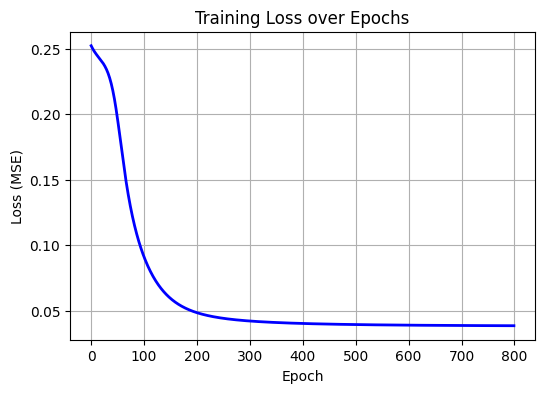

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(losses, color='blue', linewidth=2)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()

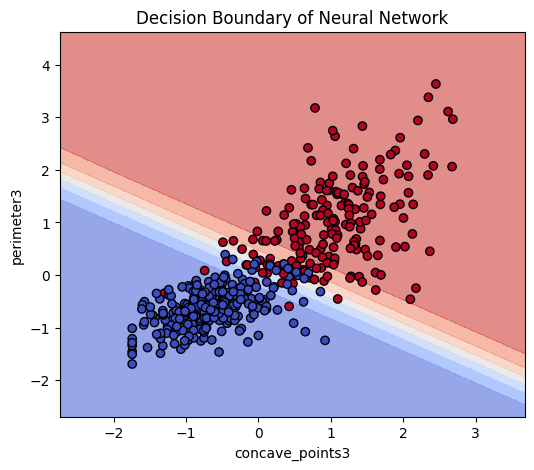

In [ ]:

X_plot = X_train[:, :2]
y_plot = y_train

x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = forward(grid)[1].reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.coolwarm)
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot.flatten(), edgecolor='k', cmap=plt.cm.coolwarm)
plt.title("Decision Boundary of Neural Network")
plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.show()